In [1]:
from math import sqrt
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from rdkit import Chem
from scipy.stats import pearsonr
from tqdm import tqdm
from torch_geometric.loader import DataLoader
from torch_geometric.nn import global_mean_pool, global_max_pool

import random

# import clsar package
import sys, os
sys.path.insert(0, '/home/shenwanxiang/Research/bidd-clsar/')

from clsar.model.loss import ACALoss, get_best_cliff
from clsar.model.model import ACANet_PNA, get_deg  # model
from clsar.model.saver import SaveBestModel
from clsar.feature import Gen39AtomFeatures  # feature
from clsar.dataset import LSSNS  # dataset
from umap import UMAP
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style = 'white', font_scale=2)

In [2]:
gpuid = 1
torch.cuda.set_device(gpuid)
print(torch.cuda.current_device())

1


In [3]:
import os, random
import numpy as np
seed = 42
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [4]:
device=torch.device("cuda")

In [5]:
def train(train_loader, device, optimizer, model, aca_loss):
    total_examples = 0
    total_loss = 0
    total_tsm_loss = 0
    total_reg_loss = 0
    n_triplets = []
    n_pos_triplets = []
    model.train()
    for i, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        predictions, embeddings = model(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)

        loss_out = aca_loss(labels=data.y,
                            predictions=predictions,
                            embeddings=embeddings)

        loss, reg_loss, tsm_loss, n, n_pos = loss_out

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs
        total_reg_loss += float(reg_loss) * data.num_graphs
        total_examples += data.num_graphs

        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))

    train_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))

    return train_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets



@torch.no_grad()
def test(test_loader, device, model, aca_loss):
    total_examples = 0
    total_loss = 0
    total_tsm_loss = 0
    total_reg_loss = 0
    n_triplets = []
    n_pos_triplets = []
    mse = []
    model.eval()
    for i, data in enumerate(test_loader):
        data = data.to(device)
        E = model.eval()
        predictions, embeddings = E(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)
        loss_out = aca_loss(labels=data.y,
                            predictions=predictions,
                            embeddings=embeddings)

        loss, reg_loss, tsm_loss, n, n_pos = loss_out

        total_loss += float(loss) * data.num_graphs
        total_tsm_loss += float(tsm_loss) * data.num_graphs
        total_reg_loss += float(reg_loss) * data.num_graphs
        total_examples += data.num_graphs

        n_triplets.append(int(n))
        n_pos_triplets.append(int(n_pos))

        mse.append(F.mse_loss(predictions, data.y, reduction='none').cpu())

    test_loss = total_loss / total_examples
    total_tsm_loss = total_tsm_loss / total_examples
    total_reg_loss = total_reg_loss / total_examples
    n_triplets = int(sum(n_triplets) / (i+1))
    n_pos_triplets = int(sum(n_pos_triplets) / (i+1))
    
    test_rmse = float(torch.cat(mse, dim=0).mean().sqrt())
    
    return test_loss, total_tsm_loss, total_reg_loss, n_triplets, n_pos_triplets, test_rmse

In [6]:
dataset_name = 'braf'
flag = 'no_aca'

pre_transform = Gen39AtomFeatures()
dataset = LSSNS(root = './tempignore/%s' % dataset_name, name=dataset_name,
                pre_transform=pre_transform)

result_save_dir = './results/%s_%s/' % (dataset_name, flag)

if not os.path.exists(result_save_dir):
    os.makedirs(result_save_dir)

epochs = 2000
batch_size = 32
lr = 1e-4
alpha = 0


pub_args = {'in_channels':pre_transform.in_channels, 
            'edge_dim':pre_transform.edge_dim,
            'out_channels':1, 
            'batch_norms':None, 
            'dropout_p': 0.0}

/home/shenwanxiang/anaconda3/envs/cuda11.3/lib/python3.9/site-packages/torch_geometric/data/dataset.py:151: UserWarning: The `pre_transform` argument differs from the one used in the pre-processed version of this dataset. If you want to make use of another pre-processing technique, make sure to sure to delete 'tempignore/braf/braf/processed' first
  warnings.warn(


In [7]:
train_dataset = dataset
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# model HPs

deg = get_deg(train_dataset)

model = ACANet_PNA(**pub_args, aggregators=['mean', 'min', 'max', 'sum'],
                     scalers=['identity', 'amplification', 'attenuation'] ,
                     deg=deg).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=10**-5)
# initialize SaveBestModel class

model_save_name = 'model_%s.pth' % dataset_name
saver = SaveBestModel(data_transformer = dataset.smiles_to_data, 
                      save_dir = result_save_dir, save_name = model_save_name)
aca_loss = ACALoss(alpha=alpha, cliff_lower=1, cliff_upper=1)

history = []
for epoch in tqdm(range(epochs), desc = 'epoch', ascii=True):
    train_loss, train_tsm, train_reg, train_n_triplets, train_n_pos_triplets = train(train_loader, device, optimizer, model, aca_loss)
    saver(train_reg, epoch, model, optimizer)
    history.append([train_loss, train_tsm, train_reg, train_n_triplets, train_n_pos_triplets])
    
saver.save()

/home/shenwanxiang/anaconda3/envs/cuda11.3/lib/python3.9/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
epoch: 100%|########################################################################| 2000/2000 [01:08<00:00, 29.19it/s]


Saving final model...

Best validation loss: 0.056438032537698746

Saving best model for epoch: 1951



In [8]:
device=torch.device("cpu")

@torch.no_grad()
def _predict(smiles_list, transformer, model):
    #test_loader, device, model):
    data_list = transformer(smiles_list)
    data_loader = DataLoader(data_list, batch_size=batch_size, shuffle=False)
    embeds = []
    preds = []
    model.eval()
    for data in data_loader:
        data = data.to(device)
        predictions, embeddings = model(data.x.float(), data.edge_index,
                                        data.edge_attr, data.batch)
        embeds.append(embeddings)
        preds.append(predictions)
        
    embeddings = torch.concat(embeds, axis=0).cpu().numpy()
    predictions = torch.concat(preds, axis=0).cpu().numpy()   
    return embeddings, predictions

In [9]:
mfile = os.path.join(result_save_dir, model_save_name)
checkpoint = torch.load(mfile, map_location=torch.device('cpu'))
model = ACANet_PNA(**checkpoint['model_args']).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
transformer = checkpoint['data_transformer']
dfm = pd.read_csv('./chemical_space.csv', index_col='smiles')
smiles_list = dfm.index.to_list()

In [10]:
spread = 30
metric = 'cosine'

/home/shenwanxiang/anaconda3/envs/cuda11.3/lib/python3.9/site-packages/umap/umap_.py:1052: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


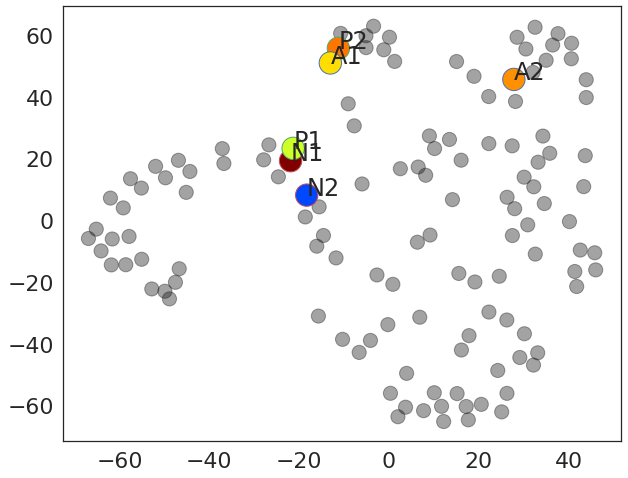

In [11]:
embeddings, predictions = _predict(smiles_list, transformer, model)

u = UMAP(random_state = seed, spread=spread, metric = metric)
xy = u.fit_transform(embeddings)
dfs = pd.DataFrame(xy,columns= ['dim1','dim2'], index=smiles_list)


dfs['chemblid'] = dfs.index.map(dfm['Molecule ChEMBL ID'])
dfs['pred'] = predictions
dfs['true'] = dfs.index.map(dfm['pChEMBL'])

dfs['node_color'] = dfs.index.map(dfm['node_color'])
dfs['edgecolor'] = dfs.index.map(dfm['edgecolor'])
dfs['node_size'] = dfs.index.map(dfm['node_size'])
dfs['label'] = dfs.index.map(dfm['label'])

dfs1 = dfs[dfs.label == 'data']
dfs2 = dfs[dfs.label != 'data']

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(dfs1.dim1, dfs1.dim2, c = 'k', alpha = 0.4, s = dfs1.node_size, edgecolors = dfs1.edgecolor)
ax.scatter(dfs2.dim1, dfs2.dim2, c = dfs2.node_color, s = 500, edgecolors = dfs2.edgecolor)
for i in range(len(dfs2)):
    ts = dfs2.iloc[i]
    ax.text(ts.dim1, ts.dim2, ts.label)
    

/home/shenwanxiang/anaconda3/envs/cuda11.3/lib/python3.9/site-packages/umap/umap_.py:1052: RuntimeWarning: divide by zero encountered in power
  return 1.0 / (1.0 + a * x ** (2 * b))


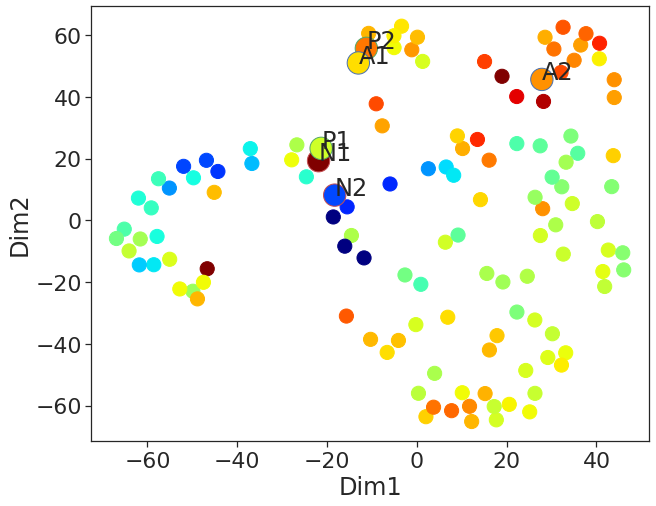

In [12]:
embeddings, predictions = _predict(smiles_list, transformer, model)

u = UMAP(random_state = seed, spread=spread, metric = metric)
xy = u.fit_transform(embeddings)
dfs = pd.DataFrame(xy,columns= ['dim1','dim2'], index=smiles_list)

dfm = pd.read_csv('./chemical_space.csv', index_col='smiles')

a, p, n = "CHEMBL3661243", "CHEMBL3661245", "CHEMBL1357167" 
dfs['chemblid'] = dfs.index.map(dfm['Molecule ChEMBL ID'])
dfs['pred'] = predictions
dfs['true'] = dfs.index.map(dfm['pChEMBL'])

dfs['node_color'] = dfs.index.map(dfm['node_color'])
dfs['edgecolor'] = dfs.index.map(dfm['edgecolor'])
dfs['node_size'] = dfs.index.map(dfm['node_size'])
dfs['label'] = dfs.index.map(dfm['label'])

dfs1 = dfs[dfs.label == 'data']
dfs2 = dfs[dfs.label != 'data']

fig, ax = plt.subplots(figsize=(10,8))

ax.scatter(dfs1.dim1, dfs1.dim2, c = dfs1.node_color,s = dfs1.node_size,)
ax.scatter(dfs2.dim1, dfs2.dim2, c = dfs2.node_color, s = 500, edgecolors = dfs2.edgecolor)
for i in range(len(dfs2)):
    ts = dfs2.iloc[i]
    ax.text(ts.dim1, ts.dim2, ts.label)
    
ax.set_xlabel('Dim1')
ax.set_ylabel('Dim2')
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

fig.savefig('./braf_latent_sapce_no_ACA.pdf', dpi = 300, bbox_inches='tight')

In [13]:
dfs2.sort_values('edgecolor')

,dim1,dim2,chemblid,pred,true,node_color,edgecolor,node_size,label
COc1cc(-c2ccc3ncnc(Nc4cccc(NS(C)(=O)=O)c4)c3c2)ccc1O,-13.011254,50.969807,CHEMBL3661236,6.413700,6.37,#ffde00,b,250,A1
COc1cc(-c2ccc3ncnc(Nc4ccc5c(c4)OCO5)c3c2)ccc1O,27.852764,45.637310,CHEMBL3661224,6.218592,6.15,#ff9100,b,250,A2
COc1ccc(Nc2ncnc3ccc(-c4ccc(O)c(OC)c4)cc23)cc1O,-11.226026,55.704597,CHEMBL3661215,6.204782,6.08,#ff7700,g,250,P2
COc1cc(-c2ccc3ncnc(Nc4cc(NS(C)(=O)=O)ccc4F)c3c2)ccc1O,-21.297235,23.306089,CHEMBL3661303,6.584406,6.57,#ceff29,g,250,P1
COc1cc(-c2ccc3ncnc(Nc4ccc(F)c(O)c4)c3c2)ccc1O,-18.274746,8.152506,CHEMBL3665862,7.713577,7.63,#0048ff,r,250,N2
COc1cc(-c2ccc3nccc(Nc4cc(NS(C)(=O)=O)ccc4F)c3c2)ccc1O,-21.871515,19.301029,CHEMBL3661302,6.431060,5.37,#800000,r,250,N1


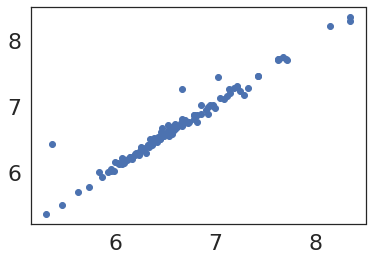

In [14]:
plt.scatter(dfs.true, dfs.pred,)

In [15]:
dfh = pd.DataFrame(history, columns=['train_loss', 'train_tsm', 'train_reg', 
                                     'train_n_triplets', 'train_n_pos_triplets'])

<AxesSubplot:>

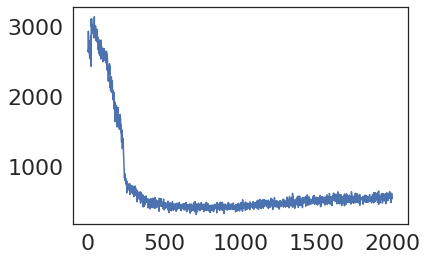

In [16]:
dfh.train_n_pos_triplets.iloc[0:].plot()

<AxesSubplot:>

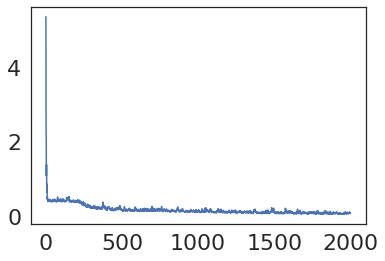

In [17]:
dfh.train_reg.iloc[2:].plot()

<AxesSubplot:>

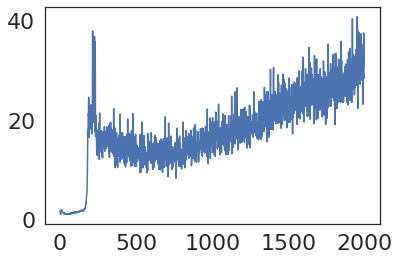

In [18]:
dfh.train_tsm.plot()

In [19]:
dfs.to_csv('./latent_space_no_aca.csv')